In [1]:
import pandas as pd
from feature_extractor import *
import keras
from keras.models import Sequential, load_model
from keras.preprocessing import sequence
from keras.layers import Dense, Flatten, GlobalMaxPooling1D, Conv1D, Embedding, Dropout, MaxPooling1D, LSTM, Bidirectional, GRU, TimeDistributed
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from rdkit.Chem import DataStructs
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv('dataset_single.csv')

In [3]:
df.head()

,P1,mol_id,smiles
0,1,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,1,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,0,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,1,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O


<AxesSubplot:ylabel='Frequency'>

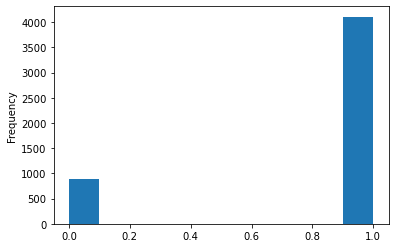

In [4]:
df['P1'].plot.hist()

In [5]:
arr = np.zeros((0,), dtype=np.int8)
df['smiles'] = df['smiles'].apply(lambda x: fingerprint_features(x))
X = df['smiles']
y = df['P1']
for j,i in enumerate(X):
    DataStructs.ConvertToNumpyArray(X.iloc[j], arr)
    X.iloc[j] = arr

/usr/local/anaconda3/envs/servier/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
X

0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
4994    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4995    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4996    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4997    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4998    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: smiles, Length: 4999, dtype: object

In [7]:
max_len = X.iloc[0].shape[0]

In [8]:
x_score, y_score = X[-200:], y[-200:]

In [9]:
X=X[:-200]
y=y[:-200]

In [20]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

In [21]:
x_score = sequence.pad_sequences(x_score, maxlen=max_len)

In [22]:
x_score.shape

(200, 2048)

In [25]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train_ix, test_ix in kfold.split(X, y):
    
    # select rows
    x_train, x_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    x_train = sequence.pad_sequences(x_train, maxlen=max_len)
    x_test = sequence.pad_sequences(x_test, maxlen=max_len)
    
  # Define the model architecture
    model = Sequential()

    model.add(Embedding(max_len, 16, input_length=max_len))
    model.add(Conv1D(32, kernel_size=(5), activation='relu'))
    model.add(MaxPooling1D(5))
    #model.add(Dropout(0.8))
    model.add(Conv1D(32, kernel_size=(5), activation='relu'))
    model.add(MaxPooling1D(5))
    
    #model.add(LSTM(10))
    #model.add(Flatten())
    #model.add(Dense(32, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    
    # Compile the model
    model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(x_train,y_train,epochs=3,batch_size=32,validation_data=(x_test,y_test))

    # Generate generalization metrics
    scores = model.evaluate(x_score, y_score, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    #acc_per_fold.append(scores[1] * 100)
    #loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1


>Train: 0=572, 1=2627, Test: 0=286, 1=1314
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 2048, 16)          32768     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 2044, 32)          2592      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 408, 32)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 404, 32)           5152      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 80, 32)            0         
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 32)                0         
_________________________________________________________________
dense_12 (

/usr/local/anaconda3/envs/servier/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3199 samples, validate on 1600 samples
Epoch 1/3
3199/3199 [==============================] - 12s 4ms/step - loss: 0.4953 - acc: 0.8143 - val_loss: 0.4769 - val_acc: 0.8213
Epoch 2/3
3199/3199 [==============================] - 11s 4ms/step - loss: 0.4707 - acc: 0.8212 - val_loss: 0.4697 - val_acc: 0.8213
Epoch 3/3
3199/3199 [==============================] - 11s 3ms/step - loss: 0.4713 - acc: 0.8212 - val_loss: 0.4700 - val_acc: 0.8213
Score for fold 1: loss of 0.4478747743368149; acc of 83.49999785423279%
>Train: 0=572, 1=2627, Test: 0=286, 1=1314
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 2048, 16)          32768     
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 2044, 32)          2592      
_________________________________________________________________
max_pooling1d_13

/usr/local/anaconda3/envs/servier/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3199 samples, validate on 1600 samples
Epoch 1/3
3199/3199 [==============================] - 12s 4ms/step - loss: 0.4847 - acc: 0.8212 - val_loss: 0.4699 - val_acc: 0.8213
Epoch 2/3
3199/3199 [==============================] - 11s 3ms/step - loss: 0.4717 - acc: 0.8212 - val_loss: 0.4699 - val_acc: 0.8213
Epoch 3/3
3199/3199 [==============================] - 11s 3ms/step - loss: 0.4725 - acc: 0.8212 - val_loss: 0.4710 - val_acc: 0.8213
Score for fold 2: loss of 0.44801791906356814; acc of 83.49999785423279%
>Train: 0=572, 1=2628, Test: 0=286, 1=1313
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 2048, 16)          32768     
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 2044, 32)          2592      
_________________________________________________________________
max_pooling1d_1

/usr/local/anaconda3/envs/servier/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3200 samples, validate on 1599 samples
Epoch 1/3
3200/3200 [==============================] - 12s 4ms/step - loss: 0.5004 - acc: 0.8138 - val_loss: 0.4718 - val_acc: 0.8211
Epoch 2/3
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4717 - acc: 0.8213 - val_loss: 0.4722 - val_acc: 0.8211
Epoch 3/3
3200/3200 [==============================] - 12s 4ms/step - loss: 0.4715 - acc: 0.8213 - val_loss: 0.4700 - val_acc: 0.8211
Score for fold 3: loss of 0.4479297119379044; acc of 83.49999785423279%


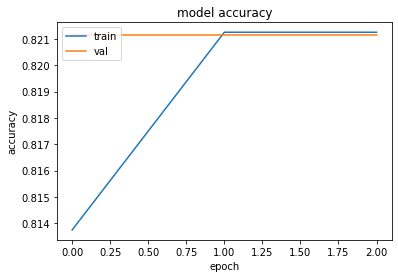

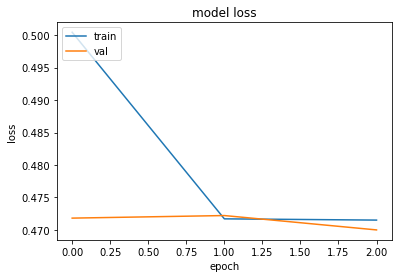

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
model.save('servier.h5')